<a href="https://colab.research.google.com/github/youngnamh/PyTorch/blob/main/02_classification_pytorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Make classification data and get it ready

In [1]:
from sklearn.datasets import make_circles

# Make 1000 samples
n_samples = 1000

X, y = make_circles(n_samples,
                    noise=0.03,
                    random_state=42)

In [2]:
len(X), len(y)

(1000, 1000)

In [3]:
print(f'First 5 samples of X:\n {X[:5]}')
print(f'First 5 samples of y:\n {y[:5]}')

First 5 samples of X:
 [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]]
First 5 samples of y:
 [1 1 1 1 0]


In [4]:
# Make DataFrame of circle data
import pandas as pd
circles = pd.DataFrame({"X1": X[:,0],
                       "X2": X[:,1],
                        "label": y})
circles.head(10)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


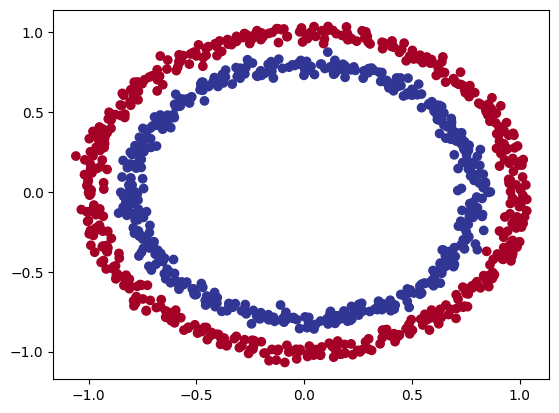

In [5]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:,0],
            y=X[:,1],
            c=y,
            cmap=plt.cm.RdYlBu);

1.1 Check input and output shapes

In [6]:
# View the first example of features and labels
X_sample = X[0]
y_sample = y[0]
print(f"Values for one sample of X: {X_sample} and the same for y: {y_sample}")
print(f"Shapes for one sample of X: {X_sample.shape} and the same for y: {y_sample.shape}")

Values for one sample of X: [0.75424625 0.23148074] and the same for y: 1
Shapes for one sample of X: (2,) and the same for y: ()


2 values of x used to predict the value of y

In [7]:
import torch
torch.__version__

'2.1.0+cu121'

In [8]:
type(X)

numpy.ndarray

In [9]:
# turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)


In [10]:
type(X), X.dtype, y.dtype

(torch.Tensor, torch.float32, torch.float32)

In [11]:
# split data intro training and test sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2, #80% train 230% test
                                                    random_state=42)

In [12]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

# Build a model

We've got some data ready, now it's time to build a model.

We'll break it down into a few parts.

1. Setting up device agnostic code (so our model can run on CPU or GPU if it's available).
2. Constructing a model by subclassing nn.Module.
3. Defining a loss function and optimizer.
4. Creating a training loop (this'll be in the next section).

In [13]:
# setup device agnostic code

import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Let's create a model class that:

1. Subclasses nn.Module (almost all PyTorch models are subclasses of nn.Module).
2. Creates 2 nn.Linear layers in the constructor capable of handling the input and output shapes of X and y.
3. Defines a forward() method containing the forward pass computation of the model.
4. Instantiates the model class and sends it to the target device.

In [14]:
# 1. Construct a model that subclasses nn.Module
class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    # 2. create 2 nn.Linear layers capable of handling the shapes of our data
    self.layer_1 = nn.Linear(in_features=2, out_features=8) #in has to match last out
    self.layer_2 = nn.Linear(in_features=8, out_features=1) #final layer ouput 1 feature, same as y

  # 3. efine a forward() method that outlines the forward pass
  def forward(self,x):
    return self.layer_2(self.layer1(x)) # X -> layer_1 -> layer_2 -> output

# 4. Instantiate an instance of our model class and send it to the target device
model0 = CircleModelV0().to(device)
model0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=1, bias=True)
)

In [15]:
device

'cpu'

In [16]:
next(model0.parameters()).device

device(type='cpu')

In [17]:
# Replicate the model above using nn.Sequential

model0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=8),
    nn.Linear(in_features=8, out_features=1)
).to(device)

model0

Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): Linear(in_features=8, out_features=1, bias=True)
)

In [18]:
model0.state_dict()

OrderedDict([('0.weight',
              tensor([[ 0.1028,  0.3506],
                      [-0.1008, -0.5781],
                      [-0.0382, -0.3955],
                      [-0.4102,  0.5025],
                      [-0.4120, -0.2208],
                      [-0.1878,  0.4855],
                      [-0.1498, -0.0662],
                      [ 0.3895, -0.4164]])),
             ('0.bias',
              tensor([ 0.5371, -0.3690,  0.2965,  0.0861,  0.6080, -0.1070,  0.4529, -0.6911])),
             ('1.weight',
              tensor([[-0.3052, -0.2913,  0.2768,  0.1906, -0.2297, -0.0666, -0.3179,  0.3129]])),
             ('1.bias', tensor([0.0546]))])

In [19]:
# Make Predictions
untrained_preds = model0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.4952],
        [-0.4346],
        [-0.5131],
        [-0.4908],
        [-0.2891],
        [-0.2539],
        [-0.2607],
        [-0.2178],
        [-0.5225],
        [-0.4281]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [20]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

# 2.1 Setup Loss Function and Optimizer

For example for regression you might want MAE

And for a binary classification problem (like ours), you'll often use binary cross entropy as the loss function.

However, the same optimizer function can often be used across different problem spaces.

For example, the stochastic gradient descent optimizer (SGD, torch.optim.SGD()) can be used for a range of problems, and the same applies to the Adam optimizer (torch.optim.Adam()).

In [21]:
# Setup loss function

loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.1)

In [22]:
# Calculate accuracy - out of 100, what percent right?

def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

# Train the model

1. Forward pass - The model goes through all of the training data once, performing its forward() function calculations (model(x_train)).
2. Calculate the loss - The model's outputs (predictions) are compared to the ground truth and evaluated to see how wrong they are (loss = loss_fn(y_pred, y_train).
3. Zero gradients - The optimizers gradients are set to zero (they are accumulated by default) so they can be recalculated for the specific training step (optimizer.zero_grad()).
4. Perform backpropagation on the loss - Computes the gradient of the loss with respect for every model parameter to be updated (each parameter with requires_grad=True). This is known as backpropagation, hence "backwards" (loss.backward()).
5. Step the optimizer (gradient descent) - Update the parameters with requires_grad=True with respect to the loss gradients in order to improve them (optimizer.step()).

In [23]:
model0.eval()
with torch.inference_mode():
  y_logits = model0(X_test.to(device))[:5]
y_logits

tensor([[-0.4952],
        [-0.4346],
        [-0.5131],
        [-0.4908],
        [-0.2891]])

In [24]:
y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.3787],
        [0.3930],
        [0.3745],
        [0.3797],
        [0.4282]])

In [25]:
y_preds = torch.round(y_pred_probs)

y_pred_labels = torch.round(torch.sigmoid(model0(X_test.to(device))[:5]))

print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

y_preds.squeeze()

tensor([True, True, True, True, True])


tensor([0., 0., 0., 0., 0.])

# Building a Training and Testing Loop


In [26]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model0.parameters(),
                            lr=0.1)

In [27]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

#put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# buiuld training and evaluation loop
for epoch in range(epochs):
  model0.train()

  # Forward Pass
  y_logits = model0(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train)

  acc= accuracy_fn(y_true=y_train,
                   y_pred=y_pred)

  #optimizer zero grad
  optimizer.zero_grad()

  # loss backward
  loss.backward()

  #optimizer step
  optimizer.step()

  #Testing
  model0.eval()
  with torch.inference_mode():
    test_logits = model0(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 10 == 0:
      print(f'Epoch: {epoch} | Loss: {loss} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.7142060995101929 | Acc: 50.00% | Test loss: 0.71243, Test acc: 50.00%
Epoch: 10 | Loss: 0.6974926590919495 | Acc: 50.00% | Test loss: 0.69853, Test acc: 50.00%
Epoch: 20 | Loss: 0.694094717502594 | Acc: 47.00% | Test loss: 0.69587, Test acc: 43.50%
Epoch: 30 | Loss: 0.6933619976043701 | Acc: 48.50% | Test loss: 0.69538, Test acc: 49.00%
Epoch: 40 | Loss: 0.6931814551353455 | Acc: 50.12% | Test loss: 0.69529, Test acc: 48.50%
Epoch: 50 | Loss: 0.6931209564208984 | Acc: 50.12% | Test loss: 0.69526, Test acc: 48.50%
Epoch: 60 | Loss: 0.6930900812149048 | Acc: 50.50% | Test loss: 0.69524, Test acc: 47.50%
Epoch: 70 | Loss: 0.6930689215660095 | Acc: 50.50% | Test loss: 0.69521, Test acc: 47.50%
Epoch: 80 | Loss: 0.6930526494979858 | Acc: 50.88% | Test loss: 0.69519, Test acc: 48.00%
Epoch: 90 | Loss: 0.6930395364761353 | Acc: 51.25% | Test loss: 0.69516, Test acc: 47.00%


In [28]:
import requests
from pathlib import Path

#Download helper functions from Learn Pytorch repo
if Path("helper_functions.py").is_file():
  print("helper functions.py already exists, skipping download")
else:
  print('Downloading helper_functions.py...')
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

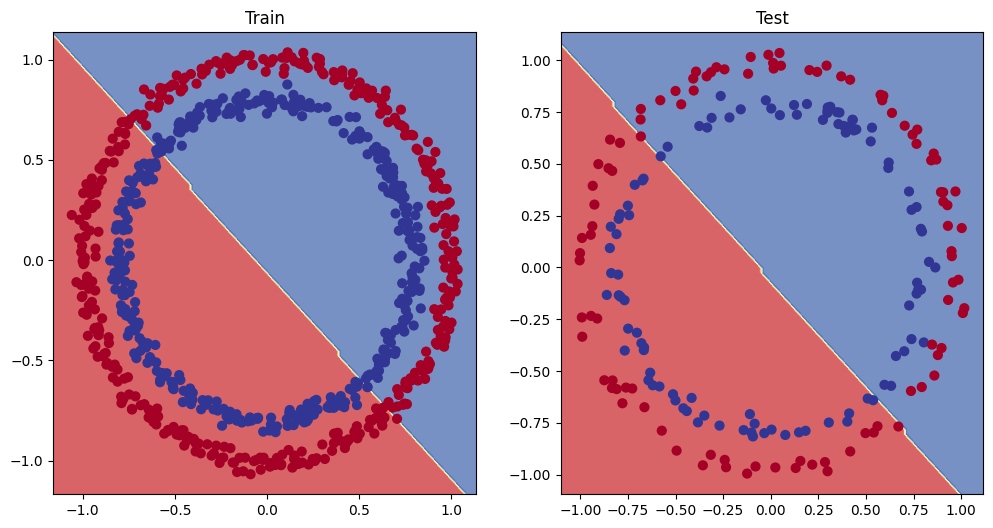

In [29]:
# Plot decision boundarty of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model0, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model0, X_test, y_test)

# Non-Linearity

In [30]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features=2, out_features=10)
    self.layer_2 = nn.Linear(in_features=10, out_features=10)
    self.layer_3 = nn.Linear(in_features=10, out_features=1)
    #non linear function
    self.relu = nn.ReLU()

  def forward(self,x):
    return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))



In [31]:
model1 = CircleModelV1().to(device)
model1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [32]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model1.parameters(),
                            lr=0.1)

In [33]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1500

#put data to target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# buiuld training and evaluation loop
for epoch in range(epochs):
  model1.train()

  # Forward Pass
  y_logits = model1(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))

  loss = loss_fn(y_logits,
                 y_train)

  acc= accuracy_fn(y_true=y_train,
                   y_pred=y_pred)

  #optimizer zero grad
  optimizer.zero_grad()

  # loss backward
  loss.backward()

  #optimizer step
  optimizer.step()

  #Testing
  model1.eval()
  with torch.inference_mode():
    test_logits = model1(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    test_loss = loss_fn(test_logits,
                        y_test)
    test_acc = accuracy_fn(y_true=y_test,
                           y_pred=test_pred)

    if epoch % 10 == 0:
      print(f'Epoch: {epoch} | Loss: {loss} | Acc: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%')

Epoch: 0 | Loss: 0.6929463148117065 | Acc: 50.00% | Test loss: 0.69319, Test acc: 50.00%
Epoch: 10 | Loss: 0.692476212978363 | Acc: 50.50% | Test loss: 0.69260, Test acc: 50.00%
Epoch: 20 | Loss: 0.6922457814216614 | Acc: 59.13% | Test loss: 0.69231, Test acc: 56.50%
Epoch: 30 | Loss: 0.6920924186706543 | Acc: 70.25% | Test loss: 0.69212, Test acc: 68.00%
Epoch: 40 | Loss: 0.6919484734535217 | Acc: 68.38% | Test loss: 0.69195, Test acc: 71.00%
Epoch: 50 | Loss: 0.6918084621429443 | Acc: 58.25% | Test loss: 0.69177, Test acc: 58.00%
Epoch: 60 | Loss: 0.6916753649711609 | Acc: 54.00% | Test loss: 0.69161, Test acc: 54.50%
Epoch: 70 | Loss: 0.691547691822052 | Acc: 53.12% | Test loss: 0.69146, Test acc: 53.00%
Epoch: 80 | Loss: 0.6914127469062805 | Acc: 52.62% | Test loss: 0.69132, Test acc: 53.00%
Epoch: 90 | Loss: 0.6912803649902344 | Acc: 52.75% | Test loss: 0.69117, Test acc: 53.00%
Epoch: 100 | Loss: 0.691152811050415 | Acc: 52.88% | Test loss: 0.69102, Test acc: 52.50%
Epoch: 110 | 

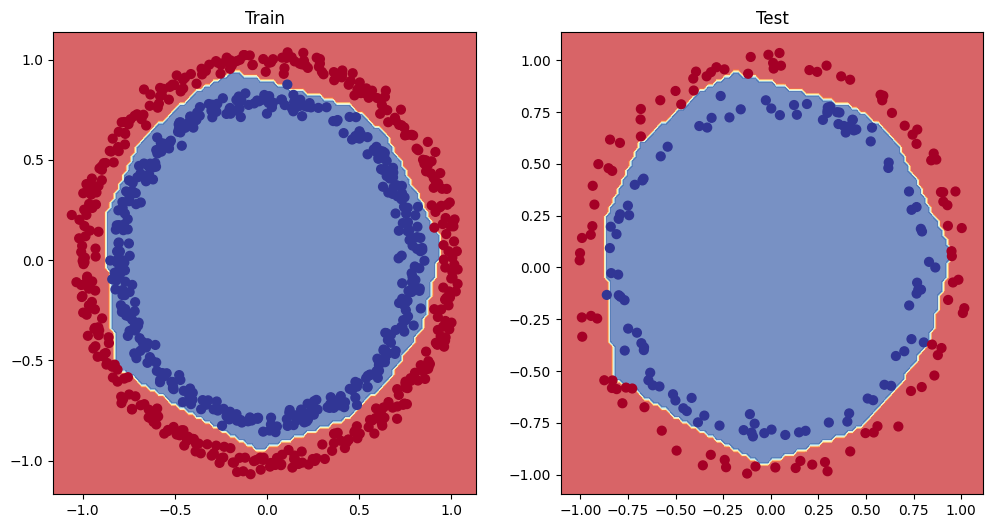

In [34]:
# Plot decision boundarty of the model

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)

# MultiClass Classification

1. Binary Classification (yes or no, one thing or another)
2. Multi Class (any amount of different things, cat vs dog vs fish, pizza vs sushi vs pasta)

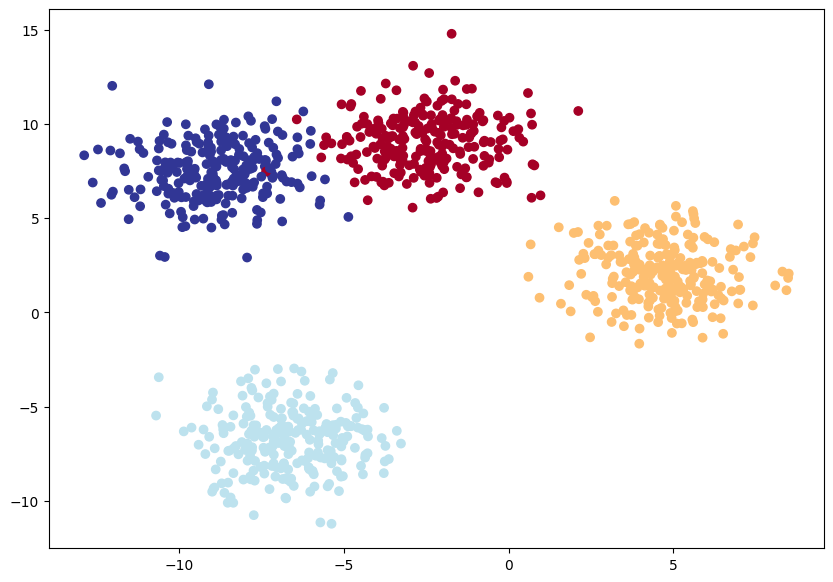

In [35]:
# toy multi class dataset

import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

X_blob, y_blob = make_blobs(n_samples=1000,
                            n_features=NUM_FEATURES,
                            centers=NUM_CLASSES,
                            cluster_std=1.5,
                            random_state=RANDOM_SEED)

X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
                                                                        y_blob,
                                                                        test_size=0.2,
                                                                        random_state=RANDOM_SEED)

plt.figure(figsize=(10,7))
plt.scatter(X_blob[:,0], X_blob[:,1], c=y_blob, cmap=plt.cm.RdYlBu)

In [36]:
# Building multi class model

class BlobModel(nn.Module):
  def __init__(self,input_features, output_features, hidden_units=8):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features)
    )

  def forward(self,x):
    return self.linear_layer_stack(x)

In [37]:
# in matches how many features x has, and out matches how many classes in our data
model2 = BlobModel(input_features=2,
                   output_features=4,
                   hidden_units=8).to(device)

model2

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [38]:
X_blob_train.shape, y_blob_train[:5], torch.unique(y_blob_train)

(torch.Size([800, 2]), tensor([1, 0, 2, 2, 0]), tensor([0, 1, 2, 3]))

In [39]:
# for classification use crossentropyloss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model2.parameters(),
                            lr=0.1)

So right now our model is outputing logits but what if we wanted to figure out exactly which label is was giving the sample?

As in, how do we go from logits -> prediction probabilities -> prediction labels just like we did with the binary classification problem?

In [40]:
model2.eval()
with torch.inference_mode():
  y_logits = model2(X_blob_test.to(device))

y_logits[:10]

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834],
        [-0.1497, -1.0617, -0.7107, -0.1645],
        [ 0.1539, -0.2887,  0.1520, -0.0109],
        [-0.2154, -1.1795, -0.9300, -0.2745],
        [ 0.2443, -0.2472,  0.1649,  0.0061],
        [-0.2329, -1.2120, -0.9849, -0.3004]])

In [41]:
y_pred_probs = torch.softmax(y_logits,dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])
print(torch.argmax(y_pred_probs[0]))

tensor([[-0.7646, -0.7412, -1.5777, -1.1376],
        [-0.0973, -0.9431, -0.5963, -0.1371],
        [ 0.2528, -0.2379,  0.1882, -0.0066],
        [-0.4134, -0.5204, -0.9303, -0.6963],
        [-0.3118, -1.3736, -1.1991, -0.3834]])
tensor([[0.3169, 0.3244, 0.1405, 0.2182],
        [0.3336, 0.1432, 0.2026, 0.3206],
        [0.3011, 0.1843, 0.2823, 0.2323],
        [0.3078, 0.2766, 0.1836, 0.2320],
        [0.3719, 0.1286, 0.1532, 0.3463]])
tensor(1)


In [42]:
#Convert model preds to prediction labels

y_preds= torch.argmax(y_pred_probs, dim=1)
y_preds

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 1, 0, 1, 0, 0, 0,
        0, 0, 0, 0, 3, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 1])

In [43]:
y_blob_test

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0, 0, 1, 0, 0, 0, 3, 3, 2, 3, 3, 3, 0, 1, 2,
        2, 2, 3, 0, 1, 0, 3, 1, 1, 3, 1, 2, 1, 3, 0, 2, 0, 3, 3, 2, 0, 3, 1, 1,
        0, 3, 1, 0, 1, 1, 3, 2, 1, 1, 3, 2, 2, 0, 3, 2, 2, 0, 0, 3, 3, 0, 0, 3,
        3, 3, 2, 3, 3, 3, 3, 1, 0, 2, 3, 2, 3, 3, 2, 3, 3, 2, 3, 3, 1, 3, 3, 3,
        1, 0, 3, 2, 0, 0, 3, 0, 2, 3, 1, 0, 3, 2, 1, 1, 0, 2, 2, 3, 0, 0, 1, 2,
        2, 3, 0, 1, 2, 0, 0, 0, 2, 3, 1, 2, 3, 2, 0, 3, 0, 0, 1, 1, 1, 0, 2, 2,
        2, 2, 0, 3, 3, 2, 2, 1, 3, 2, 0, 0, 3, 3, 2, 1, 2, 0, 3, 2, 0, 3, 2, 0,
        2, 2, 2, 0, 3, 1, 1, 1, 1, 1, 3, 1, 0, 2, 2, 1, 2, 2, 0, 1, 2, 2, 0, 0,
        1, 3, 2, 0, 3, 1, 2, 1])

# Create training loop for multi class model

In [44]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

#put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

# buiuld training and evaluation loop
for epoch in range(epochs):
  model2.train()

  # Forward Pass
  y_logits = model2(X_blob_train)
  y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
  # print(y_logits)
  # 2. Calculate loss and accuracy
  loss = loss_fn(y_logits, y_blob_train)
  acc = accuracy_fn(y_true=y_blob_train,
                    y_pred=y_pred)

  # 3. Optimizer zero grad
  optimizer.zero_grad()

  # 4. Loss backwards
  loss.backward()

  # 5. Optimizer step
  optimizer.step()

  ### Testing
  model2.eval()
  with torch.inference_mode():
    # 1. Forward pass
    test_logits = model2(X_blob_test)
    test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
    # 2. Calculate test loss and accuracy
    test_loss = loss_fn(test_logits, y_blob_test)
    test_acc = accuracy_fn(y_true=y_blob_test,
                            y_pred=test_pred)

  # Print out what's happening
  if epoch % 10 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.15883, Acc: 40.38% | Test Loss: 1.07554, Test Acc: 48.00%
Epoch: 10 | Loss: 0.64476, Acc: 96.75% | Test Loss: 0.66069, Test Acc: 97.50%
Epoch: 20 | Loss: 0.42535, Acc: 98.50% | Test Loss: 0.43074, Test Acc: 100.00%
Epoch: 30 | Loss: 0.25294, Acc: 99.12% | Test Loss: 0.24508, Test Acc: 99.50%
Epoch: 40 | Loss: 0.11232, Acc: 99.25% | Test Loss: 0.10229, Test Acc: 99.50%
Epoch: 50 | Loss: 0.06627, Acc: 99.25% | Test Loss: 0.05848, Test Acc: 99.50%
Epoch: 60 | Loss: 0.05068, Acc: 99.25% | Test Loss: 0.04293, Test Acc: 99.50%
Epoch: 70 | Loss: 0.04300, Acc: 99.25% | Test Loss: 0.03491, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03836, Acc: 99.25% | Test Loss: 0.02988, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03525, Acc: 99.25% | Test Loss: 0.02663, Test Acc: 99.50%


In [45]:
model2.eval()
with torch.inference_mode():
  y_logits = model2(X_blob_test)

y_pred_probs = torch.softmax(y_logits,dim=1)
y_preds = torch.argmax(y_pred_probs, dim=1)
y_preds[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

In [46]:
y_blob_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

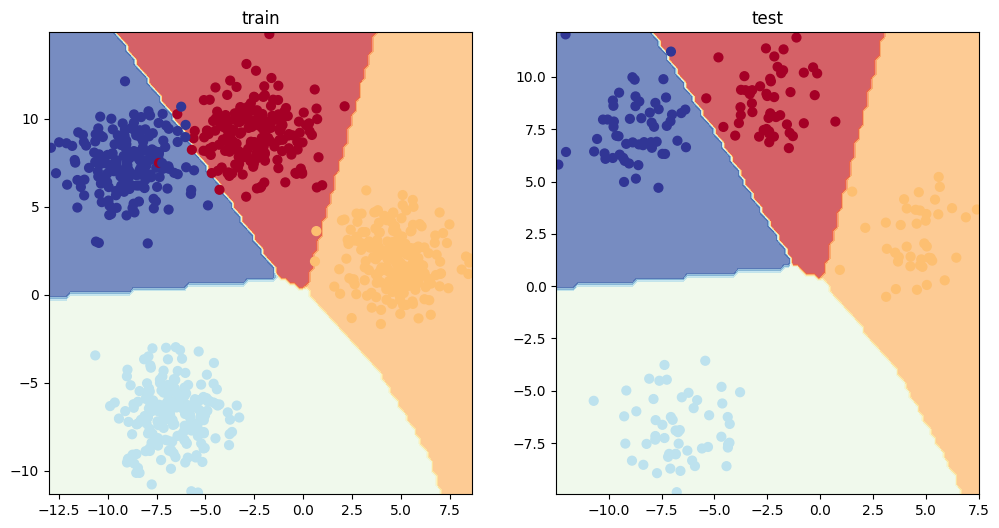

In [47]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model2, X_blob_train, y_blob_train)
plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model2,X_blob_test,y_blob_test)